# StateLattice of GameMap -- Distortion

Here we use state lattice simulated from [Pathfinding benchmark](https://www.movingai.com/benchmarks/).

This is the real dataset test of [Experiment Distortion](https://github.com/ZhiruiFeng/explorer/blob/master/test/RandomGraph.ipynb).

Then we will analysis the distortion on this graph as what we have done on random graph.

In [1]:
# Add libraries
%load_ext autoreload
%autoreload 2
import os, sys
lib_path = os.path.abspath(os.path.join('../'))
sys.path.append(lib_path)

import heuristic.fastmap.utils as utils
from heuristic.fastmap.difastmap import init_dis_store, difastmap_average, difastmap_diff, difastmap_max 
import heuristic.fastmap.analyse as analyse

import matplotlib.pyplot as plt
import networkx as nx
import random
import multiprocessing as mp
import numpy as np
import math
from random import sample

In [6]:
filepath = "../data/statelattice/arena.dimap"

G = utils.readDiGraph(filepath)

In [9]:
utils.connectivity_info(G)
countn = G.number_of_nodes()
counte = G.number_of_edges()
density = float(counte)/(countn * (countn-1))
print(countn)
print(counte)
print(density)

A strongly connected graph.
31897
103081
0.00010131938896406581


In [16]:
def get_dijkstra_path_length(G, S):
    subset = sample(list(G.nodes()), S)
    dijkstra_path_length = {}
    i = 0
    for node in subset:
        if i%10 == 0:
            sys.stdout.write("\r {}%".format(i/10))
        i+=1
        length = nx.single_source_dijkstra_path_length(G, node)
        dijkstra_path_length[node] = {}
        for theother in subset:
            dijkstra_path_length[node][theother] = length[theother]
    return dijkstra_path_length, subset

In [23]:
S = 1000
dijkstra_path_length, subset = get_dijkstra_path_length(G, S)

 99.0%

In [24]:
def thedistance_info(dijkstra_path_length, subset):
    dis = []
    for n1 in subset:
        dis.extend(dijkstra_path_length[n1].values())
    plt.hist(dis)
    plt.xlabel('distance')
    plt.ylabel('count')
    plt.title('Statistic of pair distances')
    plt.show()

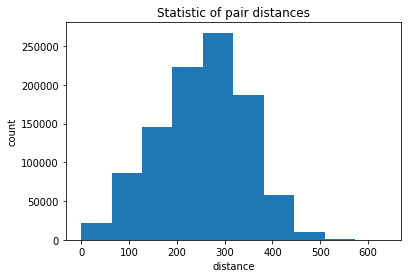

In [25]:
thedistance_info(dijkstra_path_length, subset)

## Distortion of embedding average and max

In [26]:
def meta_distortion_analyse(i):
    global G, embedding, subset, alg, variant, threshold
    node_1=subset[i]
    emb_1 = np.array(embedding[node_1])
    length = dijkstra_path_length[node_1]
    sigma = 0
    ave_d = 0
    larger = 0
    equal = 0
    smaller = 0
    for j in range(len(subset)):
        if i == j:
            continue
        node_2 = subset[j]
        emb_2 = np.array(embedding[node_2])
        distance = length[node_2]
        if variant == 'undirected':
            target_dis = distance
        elif variant == 'average':
            distance_reverse = dijkstra_path_length[node_2][node_1]
            target_dis = (float(distance) + float(distance_reverse))/2
        elif variant == 'max':
            distance_reverse = dijkstra_path_length[node_2][node_1]
            target_dis = max(float(distance), float(distance_reverse))
        elif variant == 'diff':
            distance_reverse = dijkstra_path_length[node_2][node_1]
            target_dis = abs(float(distance) - float(distance_reverse))/2
        if alg == 'L1':
            embdis = np.sum(np.abs(emb_1-emb_2))
        elif alg == 'L2':
            embdis = math.sqrt(np.dot(emb_1-emb_2, emb_1-emb_2))
        if embdis > target_dis + threshold:
            larger += 1
        elif embdis < target_dis - threshold:
            smaller += 1
        else:
            equal += 1
        sigma += (target_dis-embdis)*(target_dis-embdis)
        ave_d += target_dis
    return [sigma, ave_d, larger, equal, smaller]

def distortion_analyse_mp(G, embedding, subset, alg, variant, threshold):
    input_set = list(range(len(subset)))
    sigma = 0
    ave_d = 0
    larger = 0
    equal = 0
    smaller = 0
    pool_size = mp.cpu_count() * 2
    print("Pool size: {}".format(pool_size))
    pool = mp.Pool(processes=pool_size)
    pool_outputs = pool.map(meta_distortion_analyse, input_set)
    pool.close()
    pool.join()
    # Sum the result of metacalculation
    pool_outputs = np.array(pool_outputs)
    #print(pool_outputs)
    sigma, ave_d, larger, equal, smaller = np.sum(pool_outputs, 0)
    base = float(S)*float(S-1)
    sigma = math.sqrt(float(sigma)/base)
    ave_d = float(ave_d)/base

    return float(sigma)/ave_d, larger, equal, smaller

In [30]:
klist = [13, 14, 15, 16, 17, 18]
for K in klist:
    print("#########Test for K:{}".format(K))
    epsilon = 0.01
    threshold = 5
    alg = 'L2'
    dis_store = init_dis_store(G)
    embedding = difastmap_average(G, K, epsilon, dis_store, alg)
    variant = 'average'
    results = distortion_analyse_mp(G, embedding, subset, alg, variant, threshold)
    print(results)

#########Test for K:13
Pool size: 8
(0.12877838039150638, 298340.0, 121946.0, 578714.0)
#########Test for K:14
Pool size: 8
(0.12950614126618623, 355438.0, 120322.0, 523240.0)
#########Test for K:15
Pool size: 8
(0.12056309682752811, 416212.0, 131032.0, 451756.0)
#########Test for K:16
Pool size: 8
(0.1268154203798833, 323068.0, 128128.0, 547804.0)
#########Test for K:17
Pool size: 8
(0.1268474408220042, 393132.0, 129874.0, 475994.0)
#########Test for K:18
Pool size: 8
(0.12414520156252881, 477310.0, 130748.0, 390942.0)


In [32]:
klist = [3, 4, 5, 6, 7]
for K in klist:
    print("#########Test for K:{}".format(K))
    epsilon = 0.01
    threshold = 5
    alg = 'L1'
    dis_store = init_dis_store(G)
    embedding = difastmap_average(G, K, epsilon, dis_store, alg)
    variant = 'average'
    results = distortion_analyse_mp(G, embedding, subset, alg, variant, threshold)
    print(results)

#########Test for K:3
Pool size: 8
(0.39489004746822365, 74322.0, 28130.0, 896548.0)
#########Test for K:4
Pool size: 8
(0.3170990506266598, 178814.0, 46924.0, 773262.0)
#########Test for K:5
Pool size: 8
(0.28889902820772717, 421194.0, 53284.0, 524522.0)
#########Test for K:6
Pool size: 8
(0.2683341253057589, 408448.0, 59230.0, 531322.0)
#########Test for K:7
Pool size: 8
(0.3402070373955034, 733000.0, 44952.0, 221048.0)


In [35]:
klist = [3, 4, 5, 6, 7, 8, 9]
for K in klist:
    print("#########Test for K:{}".format(K))
    epsilon = 0.01
    threshold = 5
    alg = 'L2'
    dis_store = init_dis_store(G)
    embedding = difastmap_max(G, K, epsilon, dis_store, alg)
    variant = 'max'
    results = distortion_analyse_mp(G, embedding, subset, alg, variant, threshold)
    print(results)

#########Test for K:3
Pool size: 8
(0.4155907529168531, 87862.0, 23052.0, 888086.0)
#########Test for K:4
Pool size: 8
(0.3918268238014172, 109282.0, 25760.0, 863958.0)
#########Test for K:5
Pool size: 8
(0.30568985507162394, 309222.0, 40266.0, 649512.0)
#########Test for K:6
Pool size: 8
(0.2768427761850029, 406340.0, 43110.0, 549550.0)
#########Test for K:7
Pool size: 8
(0.24553490831054553, 476254.0, 49234.0, 473512.0)
#########Test for K:8
Pool size: 8
(0.25159328551666826, 540706.0, 51126.0, 407168.0)
#########Test for K:9
Pool size: 8
(0.28158832987742083, 637442.0, 45594.0, 315964.0)


In [37]:
klist = [3, 4, 5, 6]
for K in klist:
    print("#########Test for K:{}".format(K))
    epsilon = 0.01
    threshold = 2
    alg = 'L1'
    dis_store = init_dis_store(G)
    embedding = difastmap_max(G, K, epsilon, dis_store, alg)
    variant = 'max'
    results = distortion_analyse_mp(G, embedding, subset, alg, variant, threshold)
    print(results)

#########Test for K:3
Pool size: 8
(0.373166189858431, 287016.0, 13088.0, 698896.0)
#########Test for K:4
Pool size: 8
(0.3643842187700292, 396004.0, 14364.0, 588632.0)
#########Test for K:5
Pool size: 8
(0.39035047098785763, 548012.0, 14304.0, 436684.0)
#########Test for K:6
Pool size: 8
(0.35732572011050173, 661200.0, 15458.0, 322342.0)


**Conclusion**

Currently I have no idea why `average` and `max` have so different approximation.

## Test the distortion of embedding min

In [40]:
def meta_distortion_min(i):
    global G, embedding_aver, embedding_max, subset, alg
    node_1=subset[i]
    emb_aver_1 = np.array(embedding_aver[node_1])
    emb_max_1 = np.array(embedding_max[node_1])
    length = dijkstra_path_length[node_1]
    sigma = 0
    ave_d = 0
    for j in range(len(subset)):
        if i == j:
            continue
        node_2 = subset[j]
        emb_aver_2 = np.array(embedding_aver[node_2])
        emb_max_2 = np.array(embedding_max[node_2])
        distance = length[node_2]
        distance_reverse = dijkstra_path_length[node_2][node_1]
        target_dis = min(float(distance), float(distance_reverse))
        if alg == 'L1':
            embdis_aver = np.sum(np.abs(emb_aver_1-emb_aver_2))
            embdis_max = np.sum(np.abs(emb_max_1-emb_max_2))
        elif alg == 'L2':
            embdis_aver = math.sqrt(np.dot(emb_aver_1-emb_aver_2, emb_aver_1-emb_aver_2))
            embdis_max = math.sqrt(np.dot(emb_max_1-emb_max_2, emb_max_1-emb_max_2))
        embdis = 2.0*embdis_aver - embdis_max
        sigma += (target_dis-embdis)*(target_dis-embdis)
        ave_d += target_dis
    return [sigma, ave_d]

def distortion_min_mp(G, embedding_aver, embedding_max, subset, alg):
    input_set = list(range(len(subset)))
    sigma = 0
    ave_d = 0
    pool_size = mp.cpu_count() * 2
    print("Pool size: {}".format(pool_size))
    pool = mp.Pool(processes=pool_size)
    pool_outputs = pool.map(meta_distortion_min, input_set)
    pool.close()
    pool.join()
    # Sum the result of metacalculation
    pool_outputs = np.array(pool_outputs)
    #print(pool_outputs)
    sigma, ave_d = np.sum(pool_outputs, 0)
    base = float(S)*float(S-1)
    sigma = math.sqrt(float(sigma)/base)
    ave_d = float(ave_d)/base
    return float(sigma)/ave_d

In [42]:
k1list = [14, 15, 16]
k2list = [6, 7, 8]
for K1 in k1list:
    for K2 in k2list:
        print("#########Test for K1:{}, K2:{}".format(K1, K2))
        epsilon = 0.01
        alg = 'L2'
        dis_store = init_dis_store(G)
        embedding_aver = difastmap_average(G, K1, epsilon, dis_store, alg)
        embedding_max = difastmap_max(G, K2, epsilon, dis_store, alg)
        results = distortion_min_mp(G, embedding_aver, embedding_max, subset, alg)
        print(results)

#########Test for K1:14, K2:6
Pool size: 8
0.42732127059268815
#########Test for K1:14, K2:7
Pool size: 8
0.40815129787493937
#########Test for K1:14, K2:8
Pool size: 8
0.4880959202016164
#########Test for K1:15, K2:6
Pool size: 8
0.4265990452345787
#########Test for K1:15, K2:7
Pool size: 8
0.49928172318939357
#########Test for K1:15, K2:8
Pool size: 8
0.4067403863002687
#########Test for K1:16, K2:6
Pool size: 8
0.5169117677366762
#########Test for K1:16, K2:7
Pool size: 8
0.4786973262480331
#########Test for K1:16, K2:8
Pool size: 8
0.414748677202301


## Test the distortion of differential heuristic

In [43]:
def edgebound(pivots, pivots_dis_i, pivots_dis_j):
    upper_ij = float('inf')
    lower_ij = 0    
    for p in pivots:
        dip = pivots_dis_i[p]
        dpj = pivots_dis_j['-'+str(p)]
        djp = pivots_dis_j[p]
        dpi = pivots_dis_i['-'+str(p)]
        temp_upper_ij = dip + dpj
        if temp_upper_ij < upper_ij:
            upper_ij = temp_upper_ij
        if dip > djp:
            temp_ij = dip - djp
            if temp_ij > lower_ij:
                lower_ij = temp_ij
        if dpj > dpi:
            temp_ij = dpj - dpi
            if temp_ij > lower_ij:
                lower_ij = temp_ij
    return lower_ij, upper_ij

def meta_distortion_dh(i):
    global G, dis_store, subset, pick
    node_1=subset[i]
    emb_1 = np.array(embedding[node_1])
    length = dijkstra_path_length[node_1]
    sigma = 0
    ave_d = 0
    for j in range(len(subset)):
        if i == j:
            continue
        node_2 = subset[j]
        emb_2 = np.array(embedding[node_2])
        distance = length[node_2]
        target_dis = distance
        lower, upper = edgebound(dis_store['pivots'], dis_store[node_1], dis_store[node_2])
        if pick == 'upper':
            embdis = upper
        elif pick == 'lower':
            embdis = lower
        elif pick == 'median':
            embdis = (float(upper)+float(lower))/2
        sigma += (target_dis-embdis)*(target_dis-embdis)
        ave_d += target_dis
    return [sigma, ave_d]

def distortion_dh_mp(G, dis_store, subset, pick='upper'):
    input_set = list(range(len(subset)))
    sigma = 0
    ave_d = 0
    pool_size = mp.cpu_count() * 2
    print("Pool size: {}".format(pool_size))
    pool = mp.Pool(processes=pool_size)
    pool_outputs = pool.map(meta_distortion_dh, input_set)
    pool.close()
    pool.join()
    # Sum the result of metacalculation
    pool_outputs = np.array(pool_outputs)
    #print(pool_outputs)
    sigma, ave_d = np.sum(pool_outputs, 0)
    base = float(S)*float(S-1)
    sigma = math.sqrt(float(sigma)/base)
    ave_d = float(ave_d)/base
    return float(sigma)/ave_d

In [44]:
klist = [3, 8, 13, 18]
for K in klist:
    print("!!!!!!!!!The number of K: {}".format(K))
    picklist = ['upper', 'lower', 'median']
    for pick in picklist:
        print("#########Test for differential heuristic:{}".format(pick))
        epsilon = 0.01
        alg = 'L2'
        dis_store = init_dis_store(G)
        embedding = difastmap_max(G, K, epsilon, dis_store, alg)
        results = distortion_dh_mp(G, dis_store, subset, pick)
        print(results)

!!!!!!!!!The number of K: 3
#########Test for differential heuristic:upper
Pool size: 8
0.8358953728675993
#########Test for differential heuristic:lower
Pool size: 8
0.44037582376521606
#########Test for differential heuristic:median
Pool size: 8
0.3341994425526674
!!!!!!!!!The number of K: 8
#########Test for differential heuristic:upper
Pool size: 8
0.5698353579690127
#########Test for differential heuristic:lower
Pool size: 8
0.28286169138264705
#########Test for differential heuristic:median
Pool size: 8
0.2566631591550971
!!!!!!!!!The number of K: 13
#########Test for differential heuristic:upper
Pool size: 8
0.4916539548069063
#########Test for differential heuristic:lower
Pool size: 8
0.24610443795119968
#########Test for differential heuristic:median
Pool size: 8
0.20802194779505073
!!!!!!!!!The number of K: 18
#########Test for differential heuristic:upper
Pool size: 8
0.46567054305493943
#########Test for differential heuristic:lower
Pool size: 8
0.22898342688472703
########

## Fine-tune the approximation of distances.

In [45]:
def edgebound(pivots, pivots_dis_i, pivots_dis_j):
    upper_ij = float('inf')
    lower_ij = 0    
    for p in pivots:
        dip = pivots_dis_i[p]
        dpj = pivots_dis_j['-'+str(p)]
        djp = pivots_dis_j[p]
        dpi = pivots_dis_i['-'+str(p)]
        temp_upper_ij = dip + dpj
        if temp_upper_ij < upper_ij:
            upper_ij = temp_upper_ij
        if dip > djp:
            temp_ij = dip - djp
            if temp_ij > lower_ij:
                lower_ij = temp_ij
        if dpj > dpi:
            temp_ij = dpj - dpi
            if temp_ij > lower_ij:
                lower_ij = temp_ij
    return lower_ij, upper_ij

def compare(pivots, pivots_dis_i, pivots_dis_j, disaver, dismax, realdis):
    lower, upper = edgebound(pivots, pivots_dis_i, pivots_dis_j)
    median = (float(lower)+float(upper))/2
    dismin = 2.0*disaver - dismax
    if dismin < 0:
        dismin = 0
    if upper <= dismin:
        state = 1
        distune = upper
        substate = 1 + np.argmin(np.abs(np.array([lower, median, upper])-realdis))
    elif upper > dismin and upper <= disaver and lower <=dismin:
        state = 2
        distune = dismin
        substate = 4 + np.argmin(np.abs(np.array([lower, dismin, median, upper])-realdis))
    elif upper > disaver and upper <= dismax and lower <=dismin: # spe
        state = 3
        distune = median
        substate = 8 + np.argmin(np.abs(np.array([lower, dismin, median, disaver, upper])-realdis))
    elif upper > dismax and lower <=dismin: # spe
        state = 4
        distune = disaver
        substate = 13 + np.argmin(np.abs(np.array([lower, dismin, median, disaver, dismax, upper])-realdis))
    elif upper <= disaver and lower > dismin:
        state = 5
        distune = lower
        substate = 19 + np.argmin(np.abs(np.array([lower, median, upper])-realdis))
    elif upper > disaver and upper <= dismax and lower <= disaver and lower > dismin:
        state = 6
        distune = disaver
        substate = 22 + np.argmin(np.abs(np.array([lower, median, disaver, upper])-realdis))
    elif upper > dismax and lower <= disaver and lower > dismin: #spe
        state = 7
        distune = dismax
        substate = 26 + np.argmin(np.abs(np.array([lower, disaver, median, dismax, upper])-realdis))
    elif upper <= dismax and lower > disaver:
        state = 8
        distune = upper
        substate = 31 + np.argmin(np.abs(np.array([lower, median, upper])-realdis))
    elif upper > dismax and lower <= dismax:
        state = 9
        distune = dismax
        substate = 34 + np.argmin(np.abs(np.array([lower, median, dismax, upper])-realdis))
    elif lower > dismax:
        state = 10
        distune = lower
        substate = 38 + np.argmin(np.abs(np.array([lower, median, upper])-realdis))
    else:
        state = 0
        distune = disaver
    return state, distune, substate

def meta_fastmap_dh(i):
    global G, embedding_aver, embedding_max, subset, alg
    node_1=subset[i]
    emb_aver_1 = np.array(embedding_aver[node_1])
    emb_max_1 = np.array(embedding_max[node_1])
    length = dijkstra_path_length[node_1]
    sigma = 0
    ave_d = 0
    compare_state = []
    for t in range(11):
        compare_state.append(0)
    compare_substate = []
    for t in range(41):
        compare_substate.append(0)
    for j in range(len(subset)):
        if i == j:
            continue
        node_2 = subset[j]
        emb_aver_2 = np.array(embedding_aver[node_2])
        emb_max_2 = np.array(embedding_max[node_2])
        distance = length[node_2]
        target_dis = distance
        if alg == 'L1':
            embdis_aver = np.sum(np.abs(emb_aver_1-emb_aver_2))
            embdis_max = np.sum(np.abs(emb_max_1-emb_max_2))
        elif alg == 'L2':
            embdis_aver = math.sqrt(np.dot(emb_aver_1-emb_aver_2, emb_aver_1-emb_aver_2))
            embdis_max = math.sqrt(np.dot(emb_max_1-emb_max_2, emb_max_1-emb_max_2))
        state, tunedis, substate = compare(dis_store['pivots'], dis_store[node_1], dis_store[node_2], embdis_aver, embdis_max, target_dis)
        compare_state[state] += 1
        compare_substate[substate] += 1 
        sigma += (target_dis-tunedis)*(target_dis-tunedis)
        ave_d += target_dis
    output = list([sigma, ave_d])
    for n in compare_state:
        output.append(n)
    for n in compare_substate:
        output.append(n)
    return output

def draw_distribution(states, xl, yl, title):
    s = sum(states)
    x = list(range(len(states)))
    y = []
    for i in range(len(states)):
        y.append(float(states[i])/s)
    plt.plot(x,y,'r-o', linewidth=1)
    plt.xlabel(xl)
    plt.ylabel(yl)
    plt.title(title)
    plt.show()
    
def fastmap_dh_distribution_mp(G, embedding_aver, embedding_max, subset, alg):
    input_set = list(range(len(subset)))
    sigma = 0
    ave_d = 0
    pool_size = mp.cpu_count() * 2
    print("Pool size: {}".format(pool_size))
    pool = mp.Pool(processes=pool_size)
    pool_outputs = pool.map(meta_fastmap_dh, input_set)
    pool.close()
    pool.join()
    # Sum the result of metacalculation
    pool_outputs = np.array(pool_outputs)
    #print(pool_outputs)
    resultsum = np.sum(pool_outputs, 0)
    sigma, ave_d = resultsum[:2]
    states = resultsum[2:13]
    substates = resultsum[13:]
    xlabel = 'states'
    ylabel = 'count (persents)'
    title = 'Distribution of DH and FastMap result'
    s = sum(states)
    x = list(range(len(states)))
    y = []
    for i in range(len(states)):
        y.append(float(states[i])/s)
    s_sub = sum(substates)
    x_sub =[0,
            0.75, 1, 1.25,
            1.7, 1.9, 2.1, 2.3,
            2.6, 2.8, 3, 3.2, 3.4,
            3.5, 3.7, 3.9, 4.1, 4.3, 4.5,
            4.75, 5, 5.25,
            5.7, 5.9, 6.1, 6.3,
            6.6, 6.8, 7, 7.2, 7.4,
            7.75, 8, 8.25,
            8.7, 8.9, 9.1, 9.3,
            9.75, 10, 10.25]
    y_sub = []
    for i in range(len(substates)):
        y_sub.append(float(substates[i])/s_sub)
    plt.plot(x,y,'r-o', linewidth=1)
    plt.plot(x_sub, y_sub, 'g-*')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    
    plt.figure(1)
    adjlist = [3,4,5,6,3,4,5,3,4,3]
    for i in range(1,11):
        tempx = [i-1, i, i+1]
        tempy = [0, y[i], 0]
        tempxsub = x_sub[sum(adjlist[:i-1])+1:sum(adjlist[:i])+1]
        tempysub = y_sub[sum(adjlist[:i-1])+1:sum(adjlist[:i])+1]
        plt.subplot(4, 3, i)
        plt.plot(tempx,tempy,'r-o', linewidth=1)
        plt.plot(tempxsub, tempysub, 'g-*')
    plt.show()
    
    upper_states = [0,0,0,0]
    upper_states[0] += states[1]
    upper_states[1] += states[2] + states[5]
    upper_states[2] += states[3] + states[6] + states[8]
    upper_states[3] += states[4] + states[7] + states[9] + states[10]
    title = 'Upper Distribution of DH and FastMap result'
    draw_distribution(upper_states, xlabel, ylabel, title)
    
    lower_states = [0,0,0,0]
    lower_states[0] += states[1] + states[2] + states[3] + states[4]
    lower_states[1] += states[5] + states[6] + states[7]
    lower_states[2] += states[8] + states[9]
    lower_states[3] += states[10]
    title = 'Lower Distribution of DH and FastMap result'
    draw_distribution(lower_states, xlabel, ylabel, title) 
    
    base = float(S)*float(S-1)
    sigma = math.sqrt(float(sigma)/base)
    ave_d = float(ave_d)/base
    return float(sigma)/ave_d

Pool size: 8


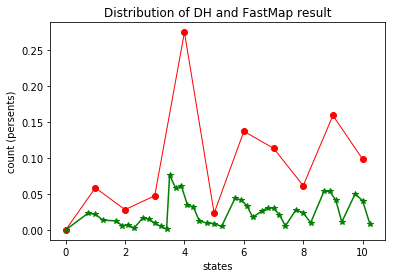

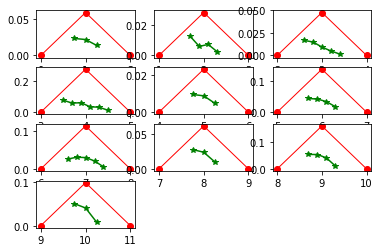

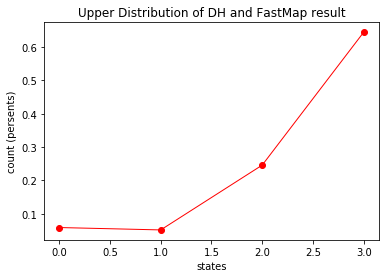

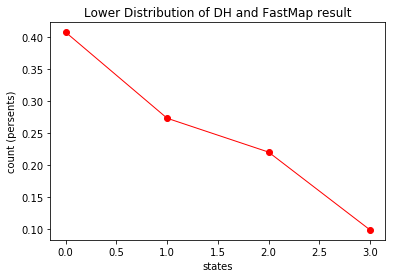

0.2204180481719387
#########Test for differential heuristic:upper
Pool size: 8
0.4356076002179444
#########Test for differential heuristic:lower
Pool size: 8
0.22298175077070725
#########Test for differential heuristic:median
Pool size: 8
0.1856954501111051


In [46]:
epsilon = 0.01
alg = 'L2'
dis_store = init_dis_store(G)
embedding_aver = difastmap_average(G, 14, epsilon, dis_store, alg)
embedding_max = difastmap_max(G, 7, epsilon, dis_store, alg)
results = fastmap_dh_distribution_mp(G, embedding_aver, embedding_max, subset, alg)
print(results)
picklist = ['upper', 'lower', 'median']
for pick in picklist:
    print("#########Test for differential heuristic:{}".format(pick))
    results = distortion_dh_mp(G, dis_store, subset, pick)
    print(results)

**Summary**

The result seems confusing, here is two plans.

1. Figure out this graph's structure.
2. And try subset bigger.